In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange
import copy

from general import *

In [2]:
class EmbTrainer():
    def __init__(self, time_dim, mod='sin', time_steps = 10, train_time_steps = 10000):
        # dim = 2 * dim_feature = 2 * ch, half_dim = dim_feature = ch
        self.time_dim = time_dim
        self.mod = mod
        self.time_steps = time_steps
        self.train_time_steps = train_time_steps
        self.emb = TimeEmbedding(dim=time_dim)
        self.criterion = nn.MSELoss()
        self.optim = optim.SGD(params=self.emb.parameters(), lr=1e-3)

    def trainer(self, x, target, vis=False):
        loss_curve = []
        y = x
        for t in range(self.train_time_steps):
            self.optim.zero_grad()
            time_step = torch.randint(0, self.time_steps, (1,)).float()
        
            if self.mod == 'sin':
                time_emb = self.emb.SinusoidalPosEmb(time_step)
            elif self.mod == 'fourier':
                time_emb = self.emb.FourieredEmb(time_step)

            time_emb = self.emb.time_mlp(time_emb)
            scale, shift = torch.chunk(time_emb, 2, dim=1)
            y = x*scale[..., None, None] + shift[..., None, None]

            loss = self.criterion(y, target)
            loss.backward(retain_graph=True)
            self.optim.step()
            loss_curve.append(loss.item())

        if vis:
            plt.plot(loss_curve)
            plt.show()
            plt.savefig('test_time_emb_loss.jpg')
        return time_emb, y
    

['data_batch_4', 'data_batch_3', 'data_batch_1', 'data_batch_2', 'data_batch_5']
datasets shape: (10000, 3072), labels shape: (10000,)
image shape:torch.Size([1, 3, 32, 32]), output shape:torch.Size([1, 3, 32, 32])


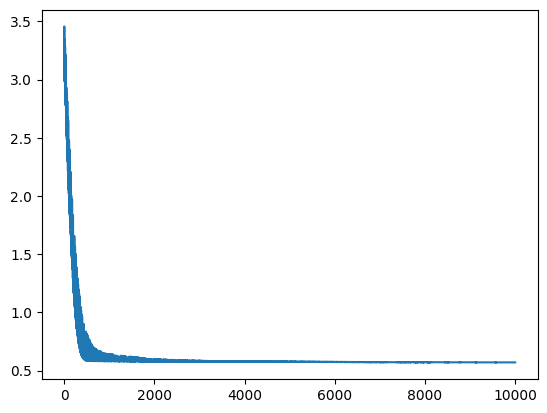

<Figure size 640x480 with 0 Axes>

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
datasets, labels = load_cifar10("./data/cifar-10-batches-py/", n_batch=1)
datasets = datasets.reshape(datasets.shape[0], 3, 32, 32)/255
img = datasets[0][None, ...]
# img = np.concatenate([img, img], axis=1)
img = torch.tensor(img, dtype=torch.float).to(device)
ch = img.shape[1]

# model = Func(dim=ch, n_class=10)

mod_emb='sin'
model = Cellmodel(ch=ch, 
            k=3, 
            time_dim=ch*2, 
            mod_emb=mod_emb,  
            time_embedding = True,
            device=device,
            vis_save=False, ).to(device)
model.eval()
trainer = EmbTrainer(time_dim=2*ch, mod=mod_emb)

t = torch.linspace(0, 10, 11)
with torch.no_grad():
    time_step = torch.randint(0, 10, (1,)).float()
    output = model(img, time_step)
    print(f'image shape:{img.shape}, output shape:{output.shape}')

    ode_result = RK4_altstep_solver(img, t=t, dt=1, u=img, func=model.ode_func)

emb_time, emb_result = trainer.trainer(img, ode_result,  vis=True)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
<ode, img> error:  1.6838137
<emb, img> error:  1.5243374
<emb, ode> error:  0.5272898


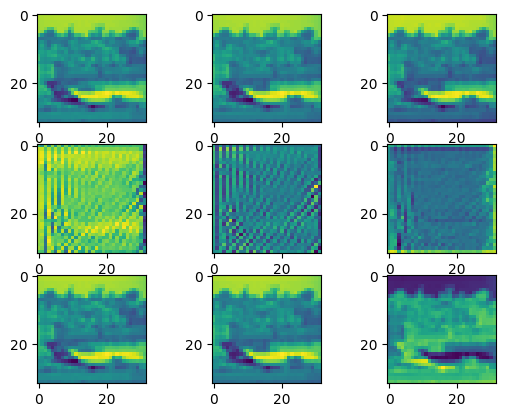

In [10]:
print(ode_result.shape)
print(emb_result.shape)
fig, ax = plt.subplots(3, 3)
for i in range(3):
    ax[0, i].imshow(img[0, i])
    ax[1, i].imshow(ode_result[0, i])
    ax[2, i].imshow(emb_result[0, i].detach().numpy())

print('<ode, img> error: ', np.mean(abs(ode_result.detach().numpy() - img.detach().numpy())))
print('<emb, img> error: ', np.mean(abs(emb_result.detach().numpy() - img.detach().numpy())))
print('<emb, ode> error: ', np.mean(abs(emb_result.detach().numpy() - ode_result.detach().numpy())))